# Nagel-Schreckenberg Traffic Model

This notebook implements a cellular automaton model for traffic flow.
It investigates the relationship between density, flow, and the formation of phantom jams.

In [1]:
# CELL 1: Imports
import numpy as np
import matplotlib.pyplot as plt
import os

# Create images directory to save plots if it doesn't exist
os.makedirs("images", exist_ok=True)

In [2]:
# CELL 2: Core Traffic Model Logic
def init_road(L, N, rng):
    """Initialize road with N cars placed randomly on length L."""
    road = -np.ones(L, dtype=int)
    pos = rng.choice(L, size=N, replace=False)
    road[pos] = 0
    return road

def step(road, v_max, p, rng):
    """
    Perform one time step of the Nagel-Schreckenberg model.
    Returns:
        new_road: The state of the road after updates
        total_distance: Total distance moved by all cars (for flow calc)
    """
    L = len(road)
    positions = np.where(road >= 0)[0]
    N = len(positions)

    new_road = -np.ones(L, dtype=int)
    total_distance = 0

    if N == 0:
        return new_road, 0

    positions.sort()
    velocities = road[positions].copy()

    for i, pos in enumerate(positions):
        v = velocities[i]
        next_pos = positions[(i + 1) % N]
        d = (next_pos - pos) % L
        
        if d == 0:
            d = L

        # [DEBUG] Check for collisions
        # if d <= 0:
        #     # print(f"Warning: Car at {pos} crashed into leader at {next_pos}")

        # 1. Acceleration
        if v < v_max:
            v += 1
            
        # 2. Deceleration (due to other cars)
        if v >= d:
            v = d - 1
            
        # 3. Randomization
        if v > 0 and rng.random() < p:
            v -= 1

        # 4. Movement
        new_pos = (pos + v) % L
        new_road[new_pos] = v
        total_distance += v

    return new_road, total_distance

In [3]:
# CELL 3: Simulation Wrapper
def run_spacetime(L, N, v_max, p, steps, seed=0, warmup=0):
    """Run simulation and return history for space-time plotting."""
    rng = np.random.default_rng(seed)
    road = init_road(L, N, rng)

    for _ in range(warmup):
        road, _ = step(road, v_max, p, rng)

    history = np.zeros((steps, L), dtype=int)
    for t in range(steps):
        history[t] = road
        road, _ = step(road, v_max, p, rng)

    return history

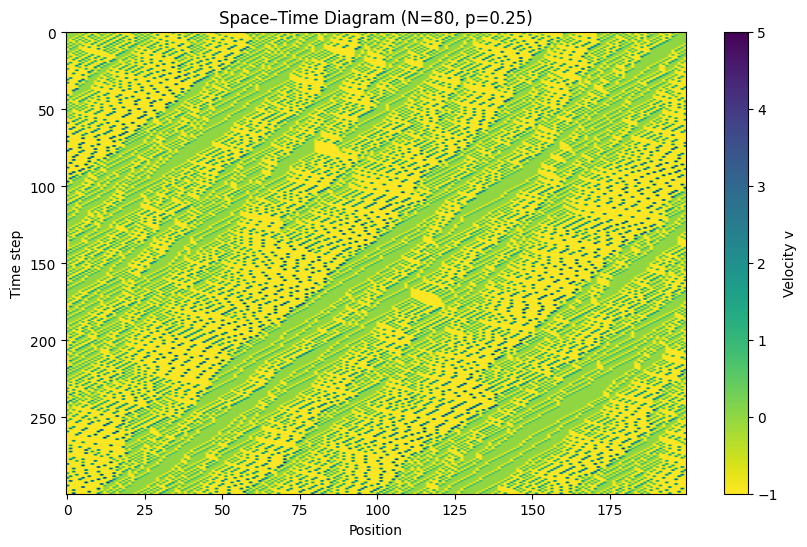

In [4]:
# CELL 4: Investigation 1 - Space-Time Diagram
# print("\n--- Running Investigation 1: Space-Time Diagram ---")

L = 200
N = 80
v_max = 5
p = 0.25

history = run_spacetime(L, N, v_max, p, steps=300)

# # print(f"Simulation finished. Output shape: {history.shape}")

plt.figure(figsize=(10, 6))
plt.imshow(history, aspect="auto", cmap="viridis_r", vmin=-1, vmax=v_max)
plt.xlabel("Position")
plt.ylabel("Time step")
plt.title(f"Space–Time Diagram (N={N}, p={p})")
plt.colorbar(label="Velocity v")
plt.show()

In [5]:
# CELL 5: Fundamental Diagram Function
def fundamental_diagram(L, v_max, p, N_values, warmup=200, measure_steps=500):
    """Calculate flow vs density."""
    rng = np.random.default_rng(1)
    densities = []
    flows = []
    
    # # print(f"Starting Fundamental Diagram calculation for {len(N_values)} density points...")

    for i, N in enumerate(N_values):
            
        road = init_road(L, N, rng)

        # Warmup phase to reach steady state
        for _ in range(warmup):
            road, _ = step(road, v_max, p, rng)

        # Measurement phase
        total_distance = 0
        for _ in range(measure_steps):
            road, dist = step(road, v_max, p, rng)
            total_distance += dist

        densities.append(N / L)
        flows.append(total_distance / (L * measure_steps))
    
    # # print("Calculation complete.")
    return np.array(densities), np.array(flows)

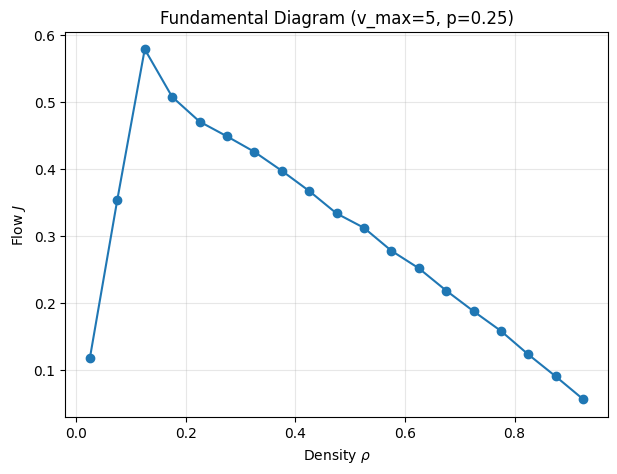

In [6]:
# CELL 6: Investigation 1 (Part 2) - Plot Fundamental Diagram
# # print("\n--- Running Investigation 1: Fundamental Diagram ---")

N_values = range(5, 195, 10)
rho, J = fundamental_diagram(L, v_max=5, p=0.25, N_values=N_values)

plt.figure(figsize=(7, 5))
plt.plot(rho, J, "o-")
plt.xlabel(r"Density $\rho$")
plt.ylabel(r"Flow $J$")
plt.title("Fundamental Diagram (v_max=5, p=0.25)")
plt.grid(True, alpha=0.3)
plt.show()

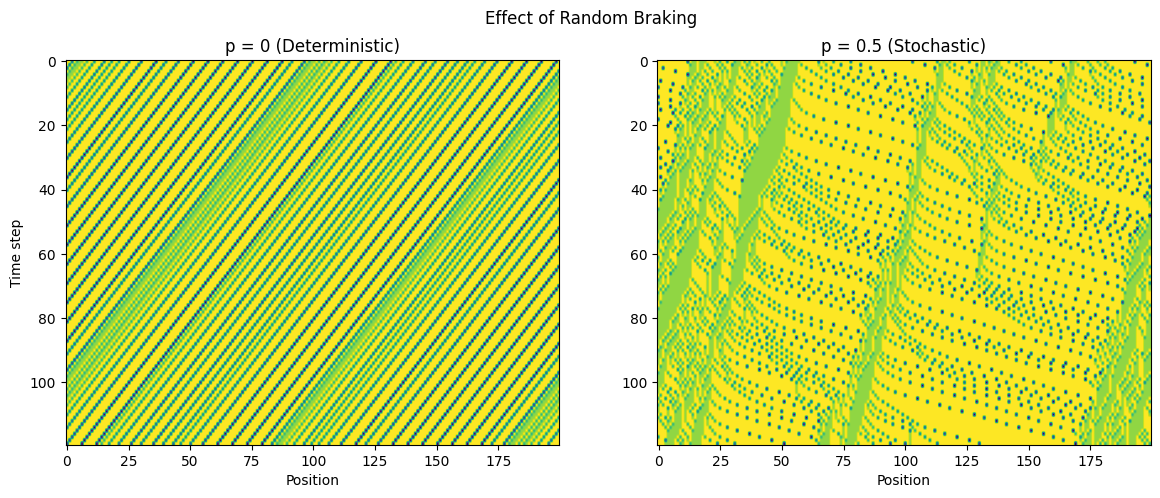

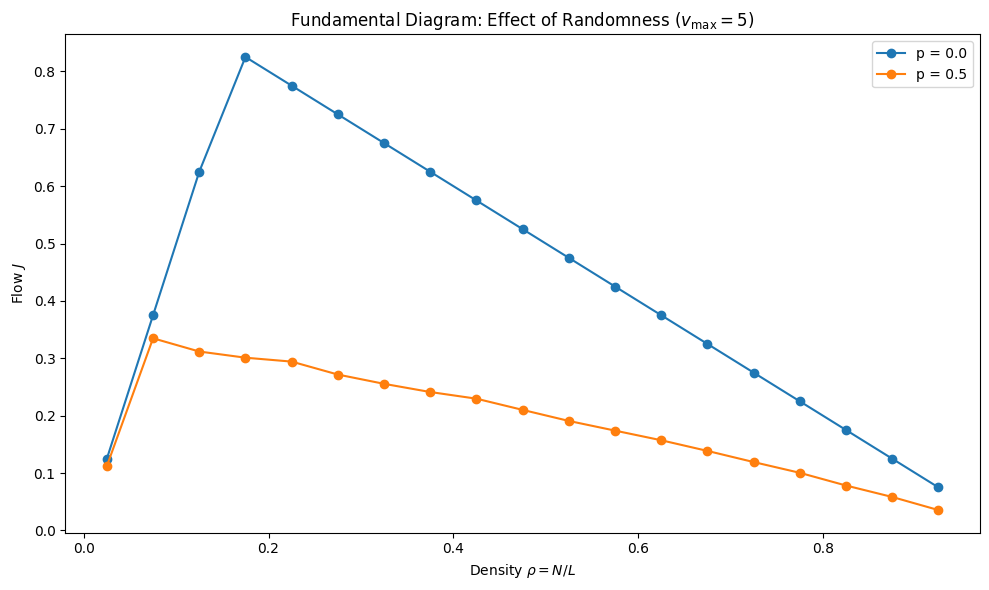

In [7]:
# CELL 7: Investigation 2 - Effect of Randomness (p)
# # print("\n--- Running Investigation 2: Effect of Randomness ---")

N = 50
# # print("Comparing p=0.0 vs p=0.5...")
history_p0 = run_spacetime(L, N, v_max=5, p=0.0, steps=120, warmup=200)
history_p5 = run_spacetime(L, N, v_max=5, p=0.5, steps=120, warmup=200)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].imshow(history_p0, aspect="auto", cmap="viridis_r", vmin=-1, vmax=5)
axes[0].set_title("p = 0 (Deterministic)")

axes[1].imshow(history_p5, aspect="auto", cmap="viridis_r", vmin=-1, vmax=5)
axes[1].set_title("p = 0.5 (Stochastic)")

for ax in axes:
    ax.set_xlabel("Position")
axes[0].set_ylabel("Time step")

plt.suptitle("Effect of Random Braking")
plt.show()

# Fundamental Diagram Comparison for p
# print("Calculating comparative Fundamental Diagrams...")
rho0, J0 = fundamental_diagram(L, v_max=5, p=0.0, N_values=N_values)
rho5, J5 = fundamental_diagram(L, v_max=5, p=0.5, N_values=N_values)

plt.figure(figsize=(10, 6))
plt.plot(rho0, J0, "o-", label="p = 0.0")
plt.plot(rho5, J5, "o-", label="p = 0.5")
plt.xlabel(r"Density $\rho = N/L$")
plt.ylabel(r"Flow $J$")
plt.title(r"Fundamental Diagram: Effect of Randomness ($v_{\max}=5$)")
plt.legend()
plt.tight_layout()
plt.savefig("images/investigation_2_fundamental_diagram_p0_vs_p05.png", dpi=300)
plt.show()

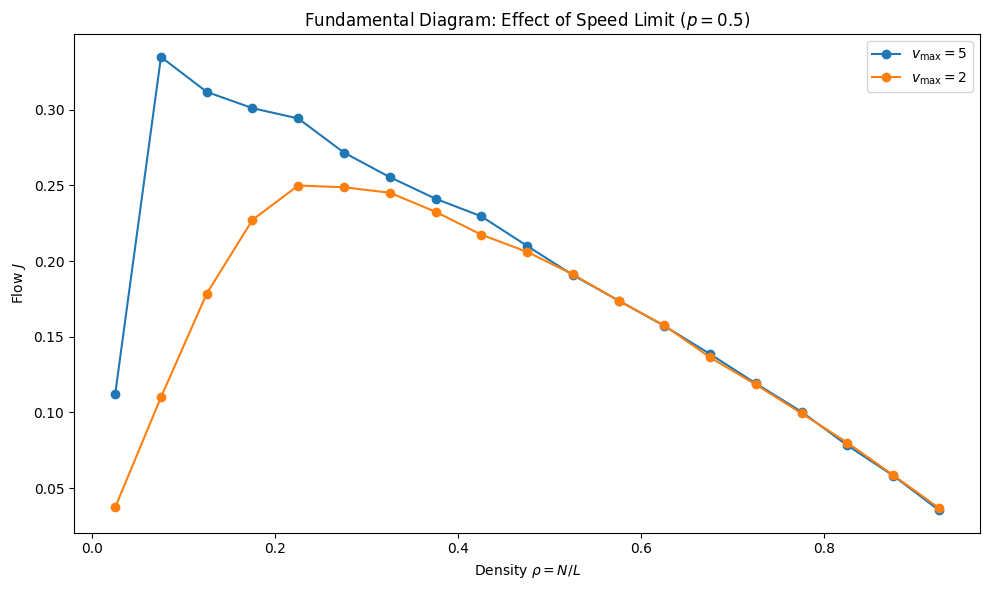

In [8]:
# CELL 8: Investigation 3 - Effect of Speed Limit
# print("\n--- Running Investigation 3: Effect of Speed Limit ---")

# Compare v_max = 5 vs v_max = 2
p = 0.5
# print(f"Comparing v_max=5 vs v_max=2 (p={p})...")

rho_v5, J_v5 = fundamental_diagram(L, v_max=5, p=p, N_values=N_values)
rho_v2, J_v2 = fundamental_diagram(L, v_max=2, p=p, N_values=N_values)

plt.figure(figsize=(10, 6))
plt.plot(rho_v5, J_v5, "o-", label=r"$v_{\max}=5$")
plt.plot(rho_v2, J_v2, "o-", label=r"$v_{\max}=2$")
plt.xlabel(r"Density $\rho = N/L$")
plt.ylabel(r"Flow $J$")
plt.title(r"Fundamental Diagram: Effect of Speed Limit ($p=0.5$)")
plt.legend()
plt.tight_layout()
plt.savefig("images/investigation_3_fundamental_diagram_vmax5_vs_vmax2.png", dpi=300)
plt.show()

# print("\nAll simulations complete.")